In [1]:
# Import

# General
import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter
import sys
import copy

# Import helper functions
from evaluation_helper import *

# Add our pipeline folder to the path to import functions
sys.path.insert(1, '../2_modeling')
from model_helper import *

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import matplotlib.image as mpimg
%matplotlib inline

# Data Processing
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_curve, auc

# Machine Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import backend as K



# List the files of saved models


In [2]:
# Paths
models_path = '../../efs/models'
checkpoint_path='../../efs/models/Checkpoints/'
training_history_path='../../efs/models/Training_history/'
saved_models_path='../../efs/models/Saved_models/'

In [3]:
# os.listdir(checkpoint_path)

In [4]:
# os.listdir(training_history_path)

# Set the parameter

In [5]:
weights='model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10'

csv = '../1_cleaning/metadata_cleaned2.csv'

number_of_images = 'all'

history=weights+'.pickle'

In [6]:
# Create train-test dataset
#name_of_model='model1_sample_sizeall_epoch50_dense2_losswbc'
# Test train split, plus the features that are used to binarize the data
X_train, X_val, y_train_bin, y_val_bin, features = train_test_split_custom(number_of_images, csv)


# Load the model

## Option 1 : load the saved model:

In [8]:
# Load the model
new_model = tf.keras.models.load_model('../../efs/models/Saved_models/' + weights + '.h5', \
                                       custom_objects={'weighted_bce': weighted_bce, 
                                                       'accuracy_on_zero': accuracy_on_zero,
                                                       'accuracy_on_one': accuracy_on_one, 
                                                       'precision_on_1': precision_on_1})

## Option 2:  load the architecture + weights

In [ ]:
# Architecture
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

transfer_layer = vgg.get_layer('block5_pool')

# cutting of the end of the model before the dense layers
conv_model = Model(inputs=vgg.input,
                   outputs=transfer_layer.output)

# freeze VGG
conv_model.trainable = False

num_label = y_train_bin.shape[1]

def create_model():
    # Start a new Keras Sequential model.
    model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    model.add(conv_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.2))
    
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.2))

    model.add(Dense(num_label, activation='sigmoid'))
    
    # Settings
    LR = 1e-5
    optimizer = Adam(lr=LR)
    loss = weighted_bce
    metrics = [accuracy_on_one, accuracy_on_zero]
    
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    return model


new_model=create_model()



In [8]:
# Checkpoint path
# For weights to be saved each epoch
#checkpoint_path = '../../efs/models/Checkpoints/' + weights + '.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Loads the weights from the checkpoint path above
new_model.load_weights(checkpoint_path+weights+'.ckpt')

# Model architecture

In [8]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 184)               9

# Predictions for the test dataset

In [9]:
# Create the datasets
# new_model.load_weights(checkpoint_path)
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [7]:
# Make the predictions
#%%time
# Takes 2:30 with 1000 images, 
# grab the predictions from the valadation ds
# predictions_test = new_model.predict(val_ds)
#predictions_train = new_model.predict(train_ds)

# SAVE the prediction
#pickle.dump(predictions_test, open( "predictions.p", "wb" ) )

In [8]:
# Optional step - load the predictions from file
#pickle.dump(predictions_test, open( "predictions.p", "wb" ) )
# Load the prediction
predictions_test= pickle.load( open( "predictions.p", "rb" ) )[0]

# Evaluations

## Loss plots

In [9]:
# Load the training history
history=pickle.load(open(training_history_path+history, "rb" ))


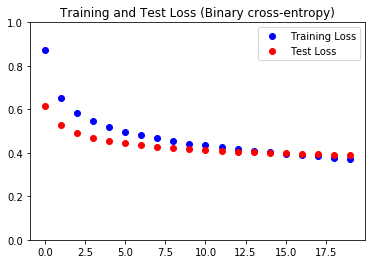

In [10]:
# Plot the training history
plot_training_history_loss(history)

## Model prediction on features that are present in photo

In [11]:
len(features)

184

(<Figure size 1584x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5eb8b2ca20>)

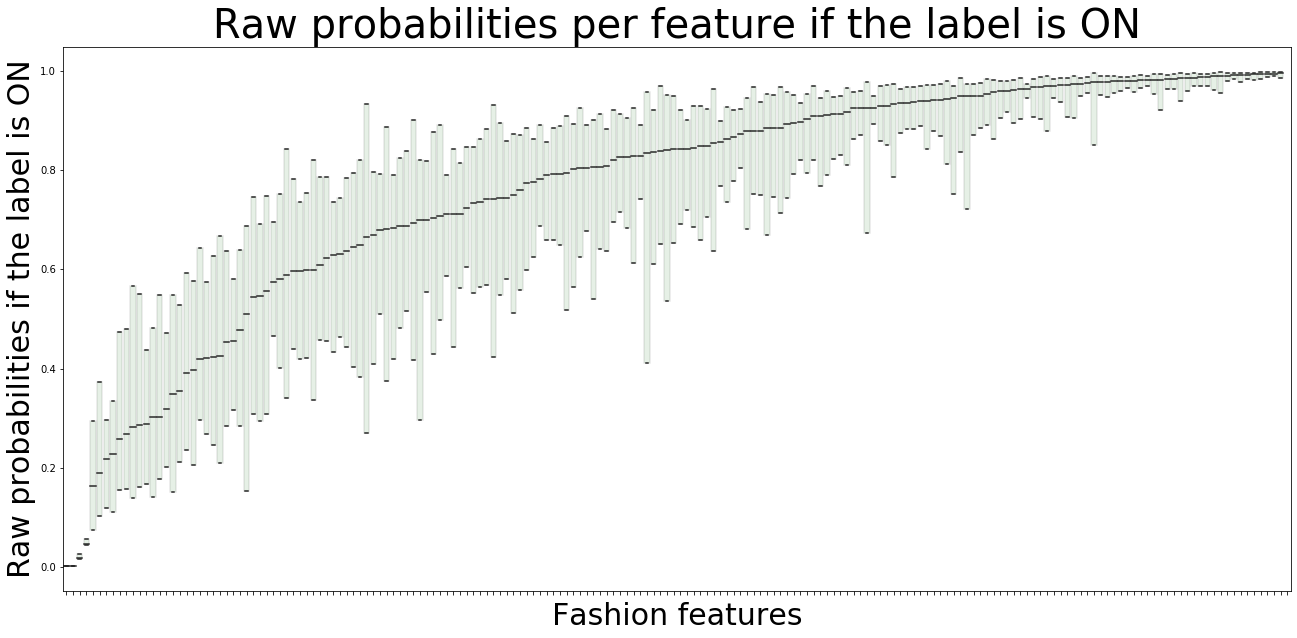

In [12]:
# Plot the predictions on 1s + the differences of medians 
plot_per_feature_error(predictions_test, y_val_bin, features)

In [13]:
only_ones = np.array([np.where(y_true == 1, pred, np.nan) for y_true, pred in zip(y_val_bin,
                                                                              predictions_test)])
pred_df = pd.DataFrame(only_ones)

# Name the classes 
pred_df.columns = features

# order the whole dataframe and return the column names
order = pred_df.median().sort_values()

## Recall on 1, recall on 0

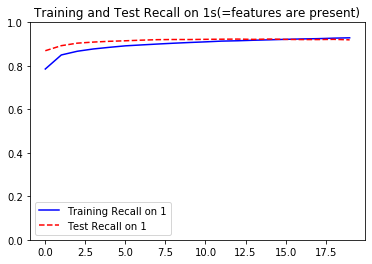

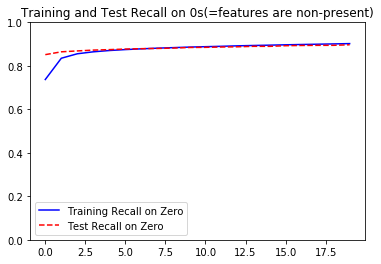

In [14]:
plot_training_history_recall_on_one(history)
plot_training_history_recall_on_zero(history)

# Precision

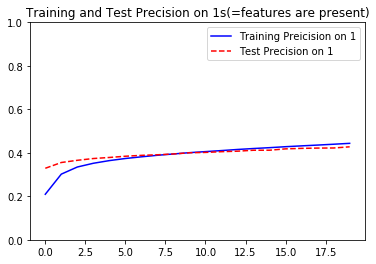

In [15]:
plot_training_history_precision_on_one(history)

## Precision - Recall curve with F1

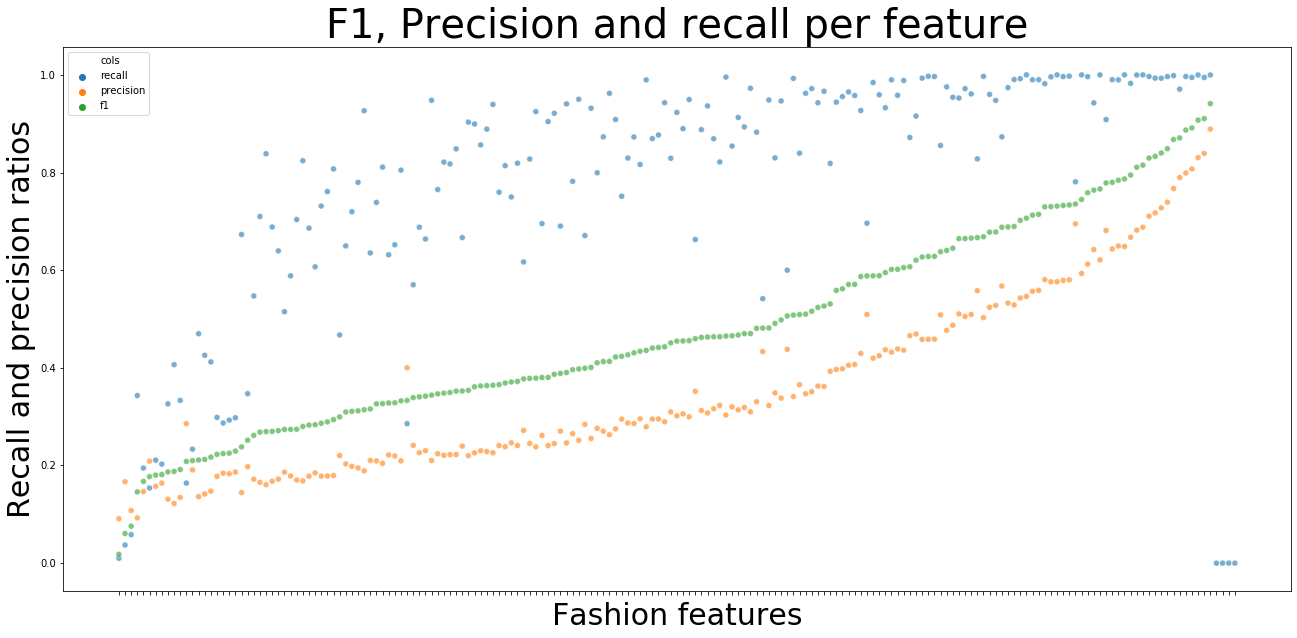

In [16]:
precision_recall_f1(y_val_bin, predictions_test, features)

## Make a prediction for an image

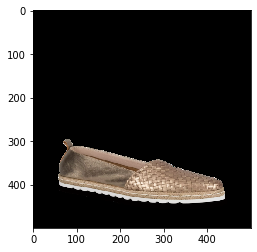

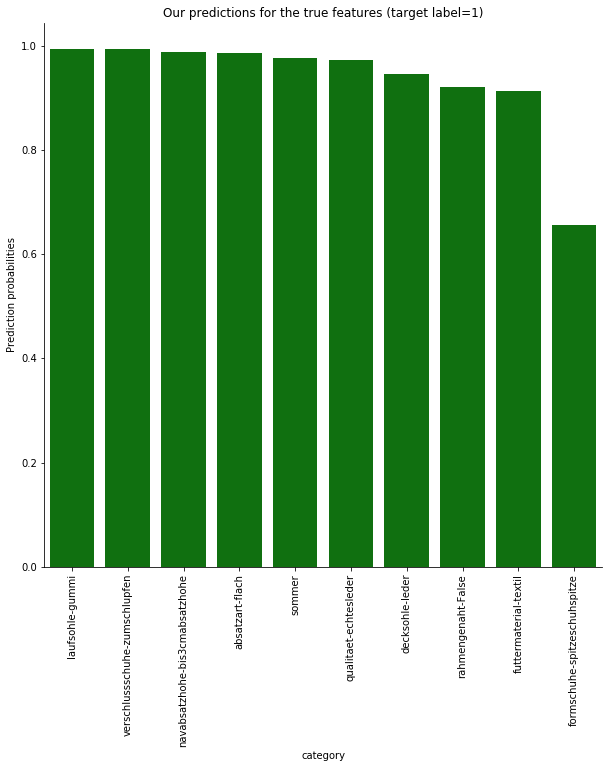

In [17]:
doPrediction(0, features, X_val, y_val_bin, predictions_test)

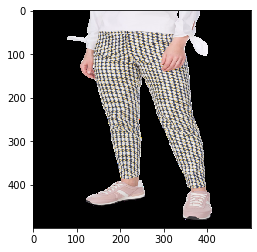

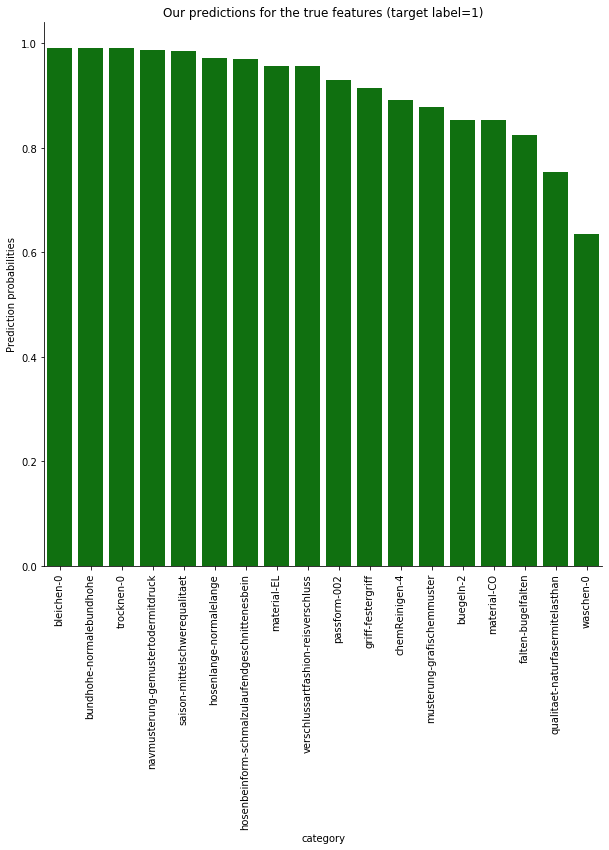

In [18]:
doPrediction(1,features, X_val, y_val_bin, predictions_test)

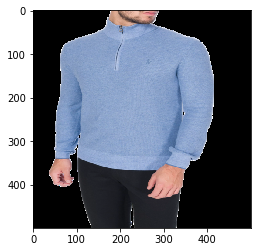

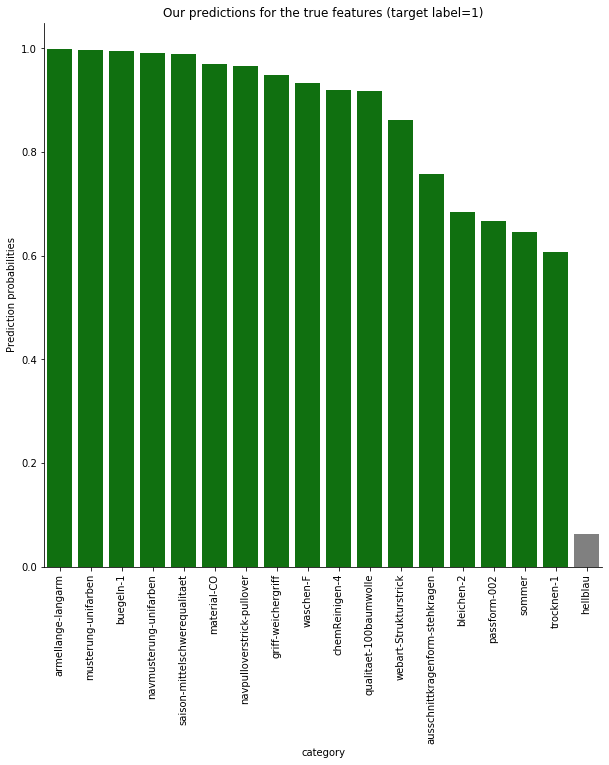

In [19]:
doPrediction(3,features, X_val, y_val_bin, predictions_test)

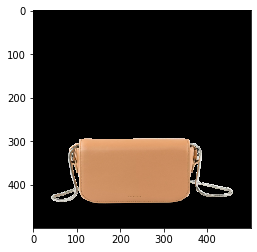

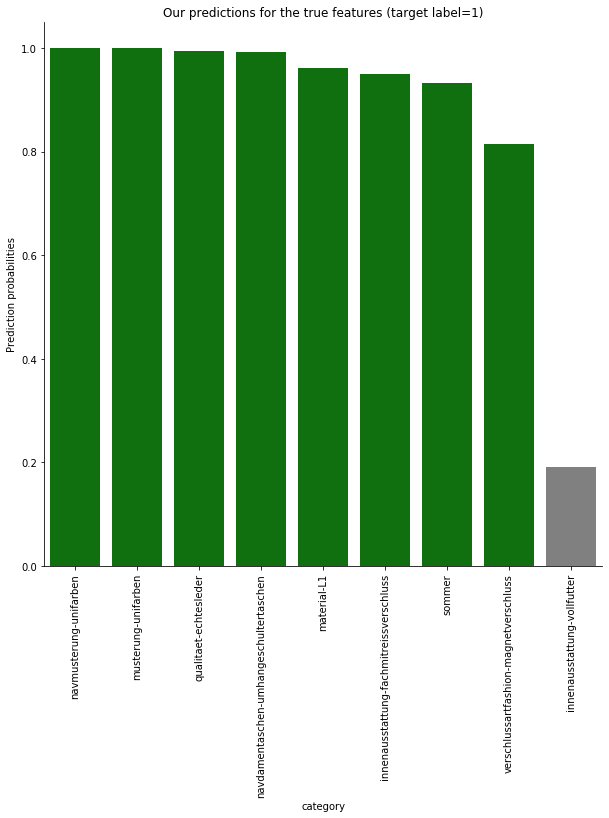

In [20]:
doPrediction(4,features, X_val, y_val_bin, predictions_test)

## ROC AUC curve

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5eb81bd438>)

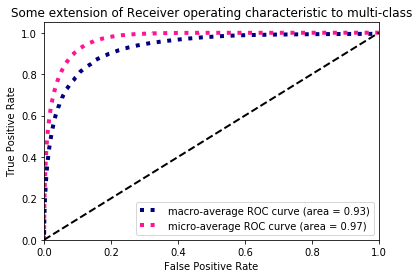

In [21]:
grouped_roc(y_val_bin, predictions_test)

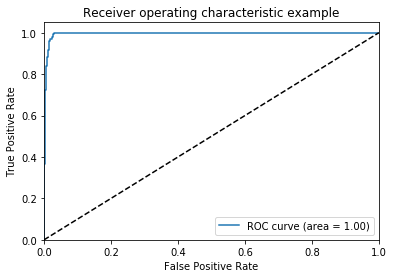

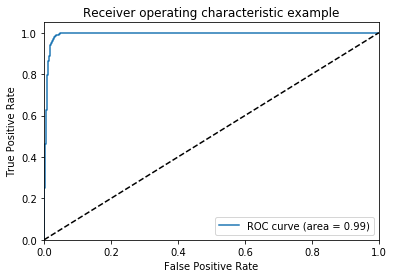

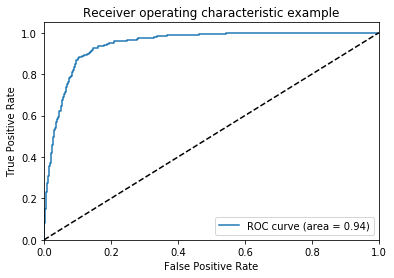

In [22]:
# Plot 3 ROC curves for 3 features
n_classes = y_val_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

    
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], predictions_test[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [23]:
# ROC AUC scores per feature
for i in range(119):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], predictions_test[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_auc

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


{0: 0.9957340508152432,
 1: 0.9928496508735654,
 2: 0.9447238387364374,
 3: 0.9915518471317158,
 4: 0.9578879248028951,
 5: 0.9969690808979246,
 6: 0.7752374067873993,
 7: 0.9661675424387288,
 8: 0.9879121632144526,
 9: 0.8528017778780858,
 10: 0.9579352747564867,
 11: 0.9902697051503154,
 12: 0.9922727406997633,
 13: 0.987149308787534,
 14: 0.9636344022035116,
 15: 0.9919107088464384,
 16: 0.9893501131643744,
 17: 0.9697833775319279,
 18: 0.9326915245402271,
 19: 0.9441695105925203,
 20: 0.8820081290997628,
 21: 0.7994406836922384,
 22: 0.9828800270396222,
 23: 0.9748495652541537,
 24: 0.9221700791609606,
 25: 0.9835632583893646,
 26: 0.8387204986878869,
 27: 0.9654004706287419,
 28: 0.9293710660316256,
 29: 0.9775620299744556,
 30: 0.933419870313074,
 31: 0.981993474921208,
 32: 0.9756150370040663,
 33: 0.936867413537006,
 34: 0.8533383863695039,
 35: 0.780426652419478,
 36: 0.8503538415005532,
 37: 0.9210371584264143,
 38: 0.8428547594491294,
 39: 0.8681180830002048,
 40: 0.86074147

# Clustering
Unsupervised clustering of the features by 3 dimensions: recall, precision, and relative feature occurrence.

In [124]:
recall_precision_frequency = create_recall_precision_frequency_df(predictions_test, y_val_bin, features)

# K means clustering on the features

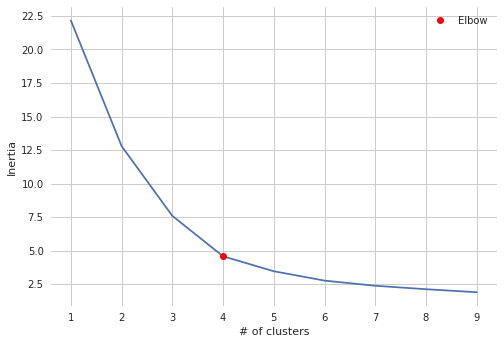

In [125]:
cluster_elbow(recall_precision_frequency,cluster_mark=4)

# Choosing 4 clusters

In [126]:
recall_precision_frequency_labeled = cluster_features(recall_precision_frequency, num_clusters=4)

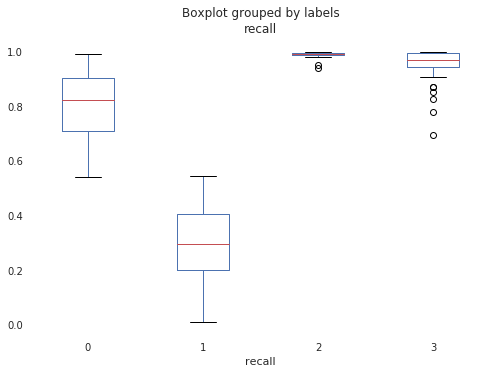

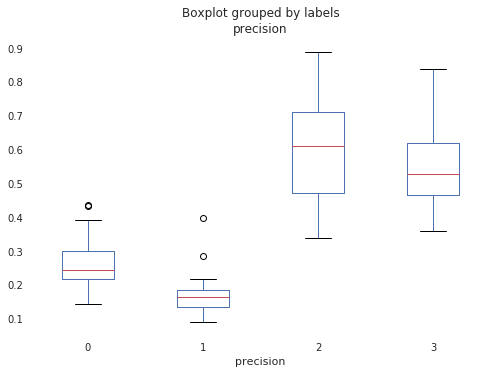

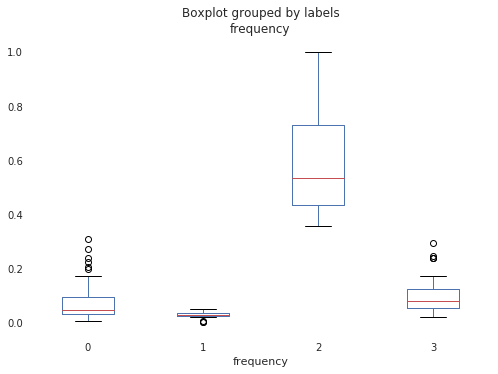

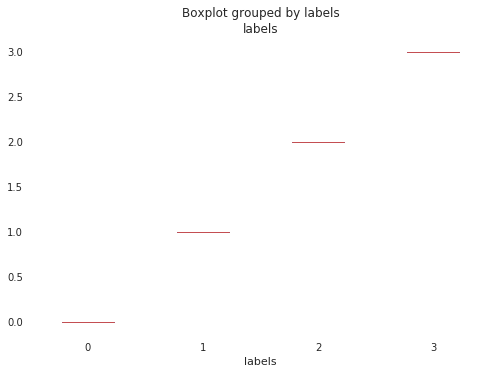

In [127]:
for feature in recall_precision_frequency.columns:
    recall_precision_frequency_labeled.boxplot(column=feature, by='labels', grid=False)
    plt.xlabel(feature)

# Heatmap of features

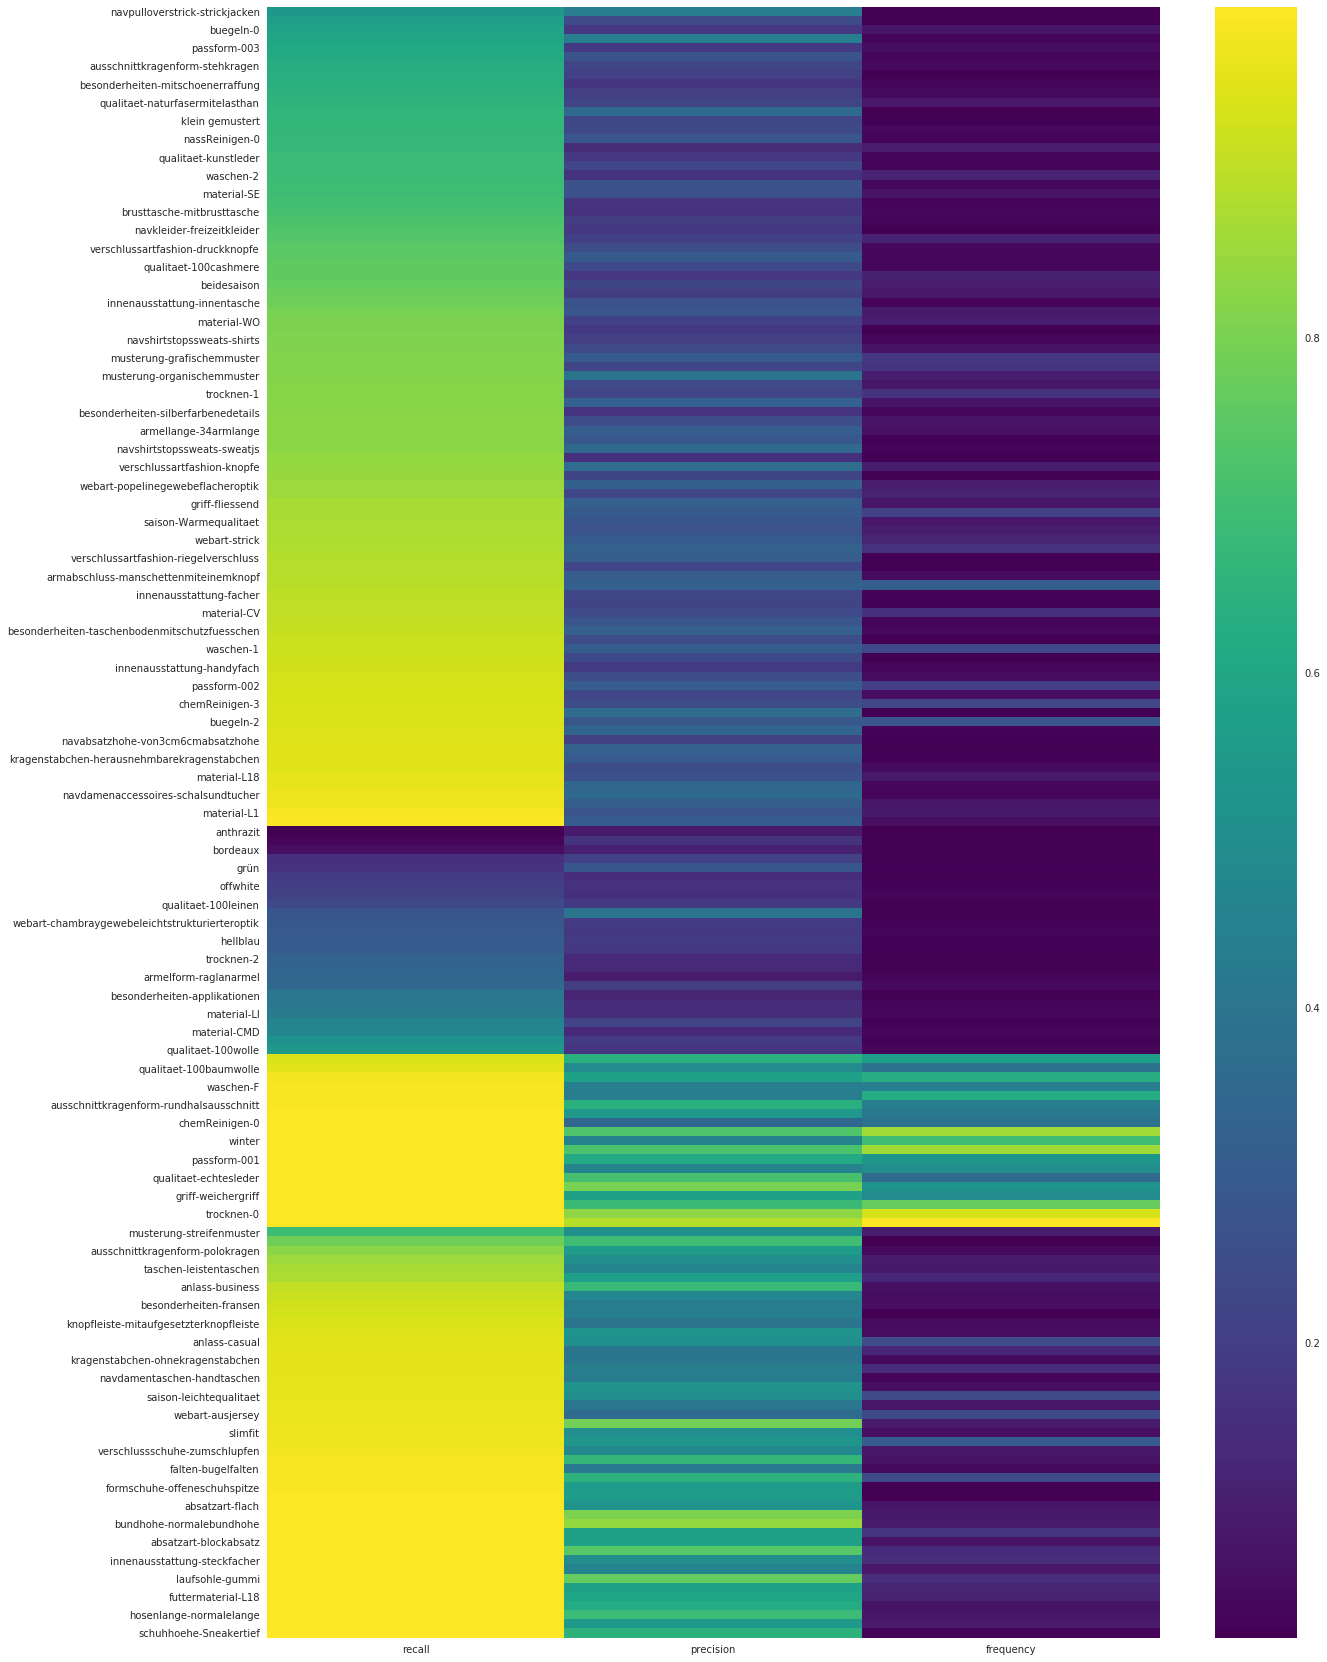

In [128]:
sortedDf = recall_precision_frequency_labeled.sort_values(by=['labels','recall'])
plt.figure(figsize=(20,30))
sns.heatmap(sortedDf.drop(labels=['labels'],axis=1), cmap='viridis', robust = True)
ax = plt.gca()
# ax.set_yticks([])


In [129]:
sortedDf.shape

(179, 4)

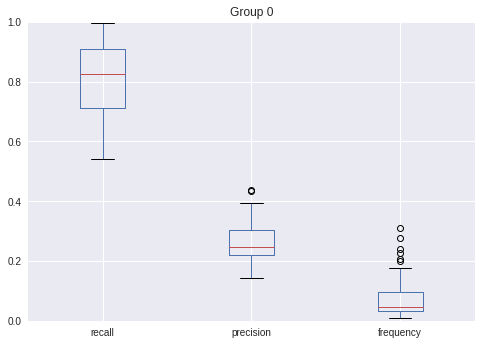

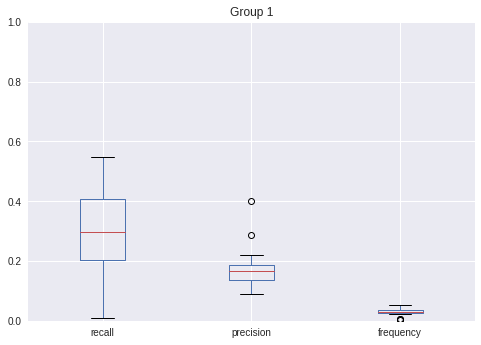

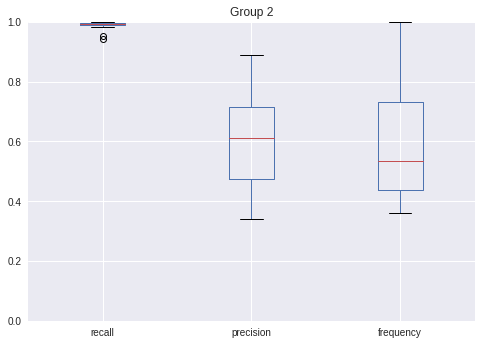

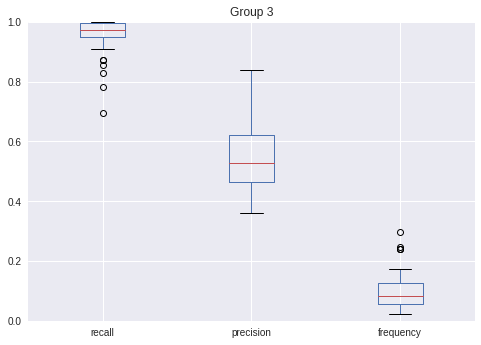

In [130]:
plt.style.use('seaborn')
# Plot by group
for group in range(4):
    temp = recall_precision_frequency_labeled[recall_precision_frequency.labels == group]
    temp[['recall','precision','frequency']].boxplot()
    plt.title('Group ' + str(group))
    plt.ylim((0, 1))
    plt.show()

# Create a 2d representation of feature groups

In [131]:
recall_precision_frequency_labeled

,recall,precision,frequency,labels
absatzart-blockabsatz,0.996466,0.579055,0.070020,3
absatzart-flach,0.990476,0.528814,0.077282,3
anlass-abend,0.690355,0.270378,0.044112,0
anlass-business,0.908425,0.681319,0.063052,3
anlass-casual,0.952565,0.510373,0.247939,3
anlass-freizeit,0.994667,0.807359,0.091708,3
anthrazit,0.010000,0.090909,0.024681,1
armabschluss-manschettenmiteinemknopf,0.889831,0.305677,0.053386,0
armabschluss-mitverstellbarenmanschetten,0.960000,0.524017,0.059814,3
armelform-raglanarmel,0.343195,0.092652,0.038665,1


In [132]:
recall_precision_frequency_labeled['f1'] = f1_score(recall_precision_frequency_labeled,'recall','precision')

In [133]:
recall_precision_frequency_labeled.columns

Index(['recall', 'precision', 'frequency', 'labels', 'f1'], dtype='object')

In [169]:
# Set the points that you could use
things_to_keep = [
    'rosa',
    'grün',
    'pink',
    'formschuhe-runderschuhspitze',
    'ausschnittkragenform-rundhalsausschnitt',
    'armellange-langarm',
    'sommer',
    'winter',
    'hosenlange-normalelange',
    'qualitaet-mischgewebemitelasthan',
    'qualitaet-kunstmischgewebe'
]

In [172]:
#Set the names of the groups
names_of_groups = ['low frequency, average recognition',
                  'low frequency, excellent recognition',
                  'high frequency, excellent recognition',
                  'low frequency, poor recognition']

recall_precision_frequency_labeled['Groups'] = recall_precision_frequency_labeled['labels'].map(dict(zip(range(4),names_of_groups)))
    

Text(0, 0.5, 'F1 score: Abiilty for the model to recognize the feature')

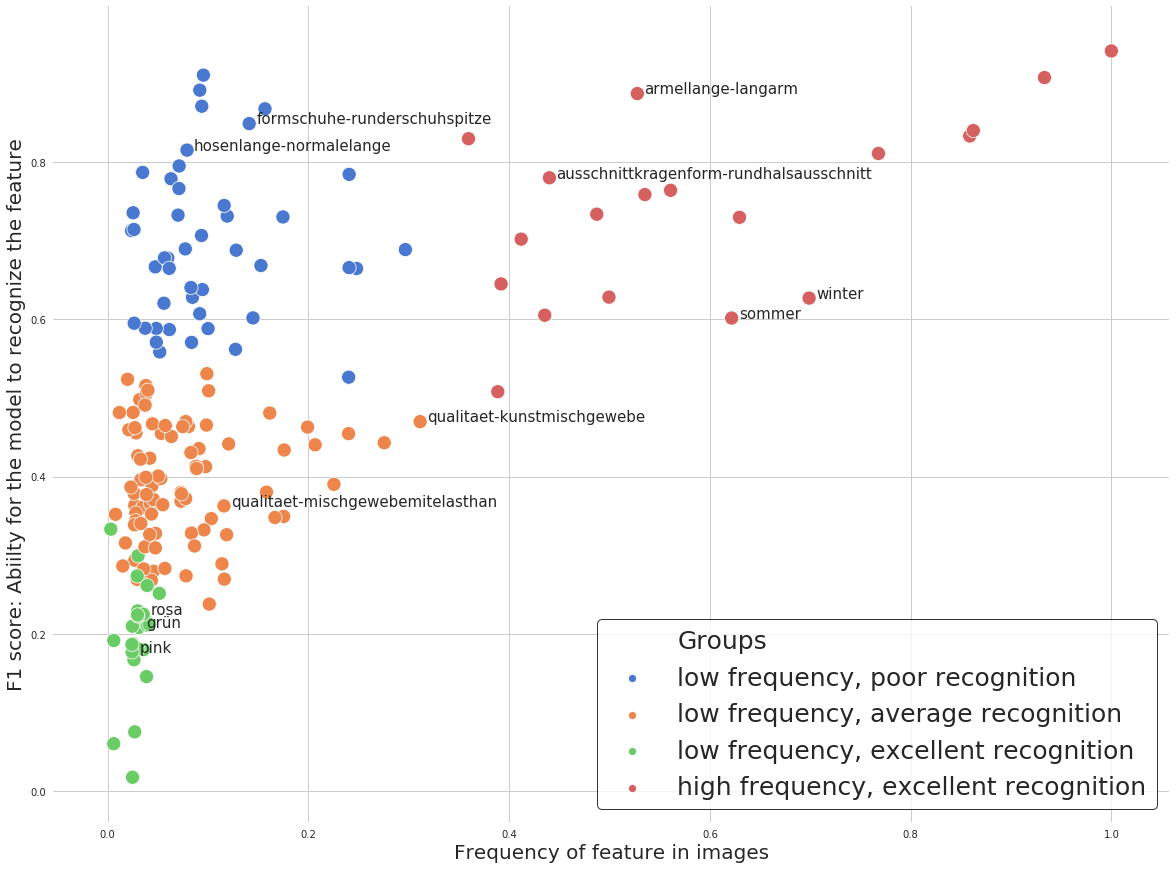

In [173]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20, 15))
sns.scatterplot( 'frequency' ,'f1', hue='Groups', 
                palette=sns.color_palette("muted",4), 
                data=recall_precision_frequency_labeled, 
                ax=ax,
                s=200)

# Moves the text to the right a little
epsilon=.007
fontsize=15
for i, txt in enumerate(recall_precision_frequency_labeled.index.to_list()):
    if txt in things_to_keep:
        ax.annotate(txt, 
                    (recall_precision_frequency_labeled.frequency[i]+epsilon, 
                     recall_precision_frequency_labeled.f1[i]),
                     fontsize=fontsize)
leg = plt.legend(loc='lower right', frameon=True, prop={'size': 25})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')


font_axes={'size':20}
ax.set_xlabel("Frequency of feature in images", font_axes)
ax.set_ylabel("F1 score: Abiilty for the model to recognize the feature", font_axes)

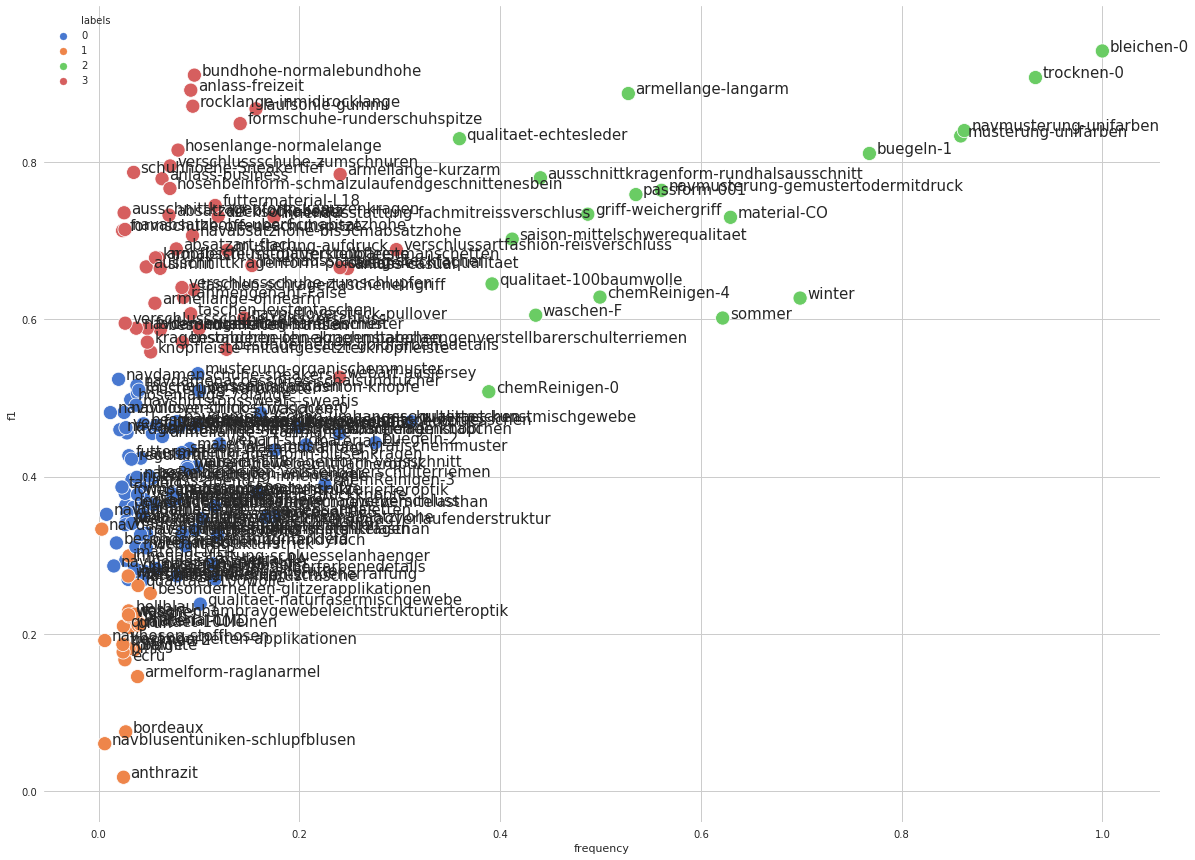

In [174]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20, 15))
sns.scatterplot( 'frequency' ,'f1', hue='labels', 
                palette=sns.color_palette("muted",4), 
                data=recall_precision_frequency_labeled, 
                ax=ax,
                s=200)

# Moves the text to the right a little
epsilon=.007
fontsize=15
for i, txt in enumerate(recall_precision_frequency_labeled.index.to_list()):
    ax.annotate(txt, 
                (recall_precision_frequency_labeled.frequency[i]+epsilon, 
                 recall_precision_frequency_labeled.f1[i]),
                 fontsize=fontsize)

In [168]:
for i in recall_precision_frequency_labeled.Groups.unique():
    print('group', i)
    print(recall_precision_frequency_labeled[recall_precision_frequency_labeled.Groups==i].index)

group low frequency, poor recognition
Index(['absatzart-blockabsatz', 'absatzart-flach', 'anlass-business',
       'anlass-casual', 'anlass-freizeit',
       'armabschluss-mitverstellbarenmanschetten', 'armellange-kurzarm',
       'armellange-ohnearm', 'ausschnittkragenform-kapuzenkragen',
       'ausschnittkragenform-polokragen',
       'besonderheiten-abnehmbarerlaengenverstellbarerschulterriemen',
       'besonderheiten-fransen', 'besonderheiten-goldfarbenedetails',
       'bundhohe-normalebundhohe', 'decksohle-leder', 'falten-bugelfalten',
       'formschuhe-offeneschuhspitze', 'formschuhe-runderschuhspitze',
       'futtermaterial-L18', 'hosenbeinform-schmalzulaufendgeschnittenesbein',
       'hosenlange-normalelange', 'innenausstattung-fachmitreissverschluss',
       'innenausstattung-steckfacher',
       'knopfleiste-mitaufgesetzterknopfleiste',
       'knopfleiste-mitglatterknopfleiste',
       'kragenstabchen-ohnekragenstabchen', 'laufsohle-gummi',
       'musterung-aufdruck',

In [115]:
recall_precision_frequency_labeled.sort_values(by='frequency',axis=0)

,recall,precision,frequency,labels,f1
navdamenschuhe-stiefelstiefeletten,0.285714,0.400000,0.003042,3,0.333333
navblusentuniken-schlupfblusen,0.037037,0.166667,0.005986,3,0.060606
navhosen-stoffhosen,0.333333,0.134615,0.006035,3,0.191781
navdamenschuhe-sandalensandaletten,0.848485,0.222222,0.007753,0,0.352201
navpulloverstrick-strickjacken,0.541667,0.433333,0.011580,0,0.481481
navkleider-freizeitkleider,0.731343,0.178182,0.015015,0,0.286550
besonderheiten-mitunterkleid,0.635294,0.210117,0.017615,0,0.315789
navdamenschuhe-sneakers,0.942857,0.362637,0.019774,0,0.523810
navblusentuniken-blusen,0.662791,0.351852,0.021050,0,0.459677
tailliert,0.921348,0.244776,0.023111,0,0.386792
